# Incomplete Installation Prediction: Model Training

**Package Versions Required** \
`numpy` v. 1.18.5 \
`pandas` v. 1.1.1 \
`seaborn` v. 0.10.1

`google-cloud-bigquery` v. 1.26.1 \
`google-auth`: 1.21.1 \
`google-cloud-bigquery-storage`: 1.0.0 \
`google-cloud-storage`: 1.30.0 \
`google-cloud-core`: 1.3.0 \
`google-api-core`: 1.22.2 \
`google-resumable-media`: 0.7.1 \
`google-auth-oauthlib`: 0.4.1

`scikit-learn` v. 0.23.2 \
`xgboost`: 1.6.1 \
`mlxtend`: 0.19.0

In [2]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# import all the required dependecnies and modules

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set_theme(style="whitegrid")
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import pickle
from google.cloud import bigquery
from google.oauth2 import service_account
# from google.cloud import bigquery_storage_v1
import string
import xgboost as xgb
import importlib
import utility as pp
import category_encoders as ce
import warnings
warnings.filterwarnings("ignore")

## Read the training data for specific month from BQ

In [4]:
import os
os.environ['gcp_service_account'] = 'ascendant-epoch-432900-m8-e97fb3b60497.json'

In [5]:
import json
# service_account_info = json.loads('ascendant-epoch-432900-m8-e97fb3b60497.json')

with open('ascendant-epoch-432900-m8-e97fb3b60497.json', 'r') as f:
        service_account_info = json.load(f)
credentials = service_account.Credentials.from_service_account_info(
    service_account_info
)
client = bigquery.Client(credentials=credentials)

In [6]:
project_id = "ascendant-epoch-432900-m8"
dataset_id = "prop_model"
table_id = "churn_train"

In [7]:
from google.cloud import bigquery
import pandas as pd

# Set your project ID
project_id = "ascendant-epoch-432900-m8"

# Initialize the BigQuery client
# client = bigquery.Client(project=project_id)

# Define your query
query = """
    SELECT
      *
    FROM
      `ascendant-epoch-432900-m8.prop_model.churn_train`
    
"""

# Run the query
query_job = client.query(query)

# Fetch the results as a pandas DataFrame
df = query_job.to_dataframe()

# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")

# Display the first few rows
print(df.head())

DataFrame shape: (7043, 21)
   customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0  9732-OUYRN  Female              0     True       False      49   
1  0661-KQHNK  Female              0     True        True       6   
2  4709-LKHYG  Female              0     True        True      29   
3  9824-QCJPK    Male              0     True       False      36   
4  4716-MRVEN  Female              0    False       False      29   

   PhoneService MultipleLines InternetService       OnlineSecurity  ...  \
0          True            No              No  No internet service  ...   
1          True            No              No  No internet service  ...   
2          True            No              No  No internet service  ...   
3          True            No              No  No internet service  ...   
4          True            No              No  No internet service  ...   

      DeviceProtection          TechSupport          StreamingTV  \
0  No internet service  No internet se

In [8]:
print(df.shape)

(7043, 21)


In [9]:
print(df.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [10]:
raw_data_res = df.copy()

In [11]:
raw_data_res['Churn'] = raw_data_res['Churn'].astype(int)

## Defining X and y Columns for Modeling

In [12]:
print('Total customers: ', raw_data_res.shape[0])
print('churners: ',raw_data_res['Churn'].sum())
print('churn rate rate %: ', round(raw_data_res["Churn"].value_counts(normalize = True)[1] * 100,2))

Total customers:  7043
churners:  1869
churn rate rate %:  26.54


In [13]:
raw_data_res['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [14]:
raw_data_res['Churn'].value_counts(normalize = True)

Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

In [15]:
raw_data_res.shape

(7043, 21)

In [16]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'column_name' is the problematic column
raw_data_res['TotalCharges'] = pd.to_numeric(raw_data_res['TotalCharges'], errors='coerce')
import numpy as np

raw_data_res['TotalCharges'] = raw_data_res['TotalCharges'].replace('', np.nan)
raw_data_res['TotalCharges'] = raw_data_res['TotalCharges'].astype(float)

In [17]:
not_use = ['customerID', 'Churn']
id = ['customerID']
target = ['Churn']

In [18]:
cat_col = []
num_col = []

for col in raw_data_res.columns:
    if raw_data_res[col].dtypes == 'object':
        cat_col.append(col)
    elif col not in target:
        num_col.append(col)

In [19]:
print("total cat cols: ", len(cat_col))
print("total num cols: ", len(num_col))

total cat cols:  12
total num cols:  8


In [20]:
for col in cat_col:
    if (col not in not_use) and (col not in target):
        unique_values = raw_data_res[col].unique()
        print(f"Column: {col}")
        print(f"Number of unique values: {len(unique_values)}")
        print(f"Unique values: {unique_values}")
        print(f"Value counts:\n{raw_data_res[col].value_counts()}")
        print(f"Value counts normalized:\n{raw_data_res[col].value_counts(normalize = True)}")
        print("-" * 50)  # Separator for readability

Column: gender
Number of unique values: 2
Unique values: ['Female' 'Male']
Value counts:
gender
Male      3555
Female    3488
Name: count, dtype: int64
Value counts normalized:
gender
Male      0.504756
Female    0.495244
Name: proportion, dtype: float64
--------------------------------------------------
Column: MultipleLines
Number of unique values: 3
Unique values: ['No' 'Yes' 'No phone service']
Value counts:
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
Value counts normalized:
MultipleLines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: proportion, dtype: float64
--------------------------------------------------
Column: InternetService
Number of unique values: 3
Unique values: ['No' 'DSL' 'Fiber optic']
Value counts:
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
Value counts normalized:
InternetService
Fiber opt

In [21]:
raw_data_res['TotalCharges'].isna().any()

True

In [22]:
all_col = cat_col + num_col

In [23]:
num_col

['SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges']

## Preprocessing

In [24]:
raw_data_res_v1 = raw_data_res[all_col]
raw_data_res_v1.shape

(7043, 20)

In [25]:
# Defining independent and target features
X = raw_data_res_v1.copy()
y = raw_data_res['Churn']

In [26]:
importlib.reload(pp)
Pipe_PP = Pipeline([
                    
                    # Demo Data
                    ('Imputation_demo_col', pp.SimpleImputer(features = cat_col, strategy='constant', missing_values=np.nan,fill_value= 'None')),
                    
                    # Comp and Sevices Col
                    ('Imputation_comp_col', pp.SimpleImputer(features = num_col, strategy='constant', missing_values=np.nan,fill_value= 0)),
#                     ('Imputation_comp_service_col', pp.SimpleImputer(features = comp_service_col, strategy='constant', missing_values=np.nan,fill_value= 'None')),
                    
#                     # other_col
#                     ('Imputation_other_cat_col', pp.SimpleImputer(features = other_cat_col, strategy='constant', missing_values=np.nan,fill_value= 'None')),
#                     ('Imputation_other_num_col', pp.SimpleImputer(features = other_num_col, strategy='constant', missing_values=np.nan,fill_value= 0)),
                    
                    
#                     # All Columns 
#                     ('RareCategory', pp.RareCategoryEncoder(features_CAT_ = rare_col, category_min_pct=0.001, category_max_count=10)), #Droping levels that has very low proportion
                    ('Constant1', pp.Remove_ConstantFeatures(unique_threshold=1, missing_threshold=0.00)), # 
                    # ('Num_Col_Covar', pp.Num_Col_Covar(X=X,  y = y, outcome_field = 'incomplete_flag'))
                  ])
# fit_transform()
X_PP = Pipe_PP.fit_transform(X)
print(X_PP.shape)
X_PP.head()

**************************************************
Pre-Processing: SimpleImputer
**************************************************
**************************************************
Pre-Processing: SimpleImputer
**************************************************
**************************************************
Feature Engineering: Remove_ConstantFeatures
**************************************************
- It will remove features with 1 unique value(s).

[] []
0 features with 1 or fewer unique value(s)
(7043, 20)


,Contract,Dependents,DeviceProtection,InternetService,MonthlyCharges,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PaymentMethod,PhoneService,SeniorCitizen,StreamingMovies,StreamingTV,TechSupport,TotalCharges,customerID,gender,tenure
0,One year,0,No internet service,No,19,No,No internet service,No internet service,0,1,Credit card (automatic),1,0,No internet service,No internet service,No internet service,918,9732-OUYRN,Female,49
1,One year,1,No internet service,No,19,No,No internet service,No internet service,0,1,Credit card (automatic),1,0,No internet service,No internet service,No internet service,105,0661-KQHNK,Female,6
2,One year,1,No internet service,No,20,No,No internet service,No internet service,0,1,Electronic check,1,0,No internet service,No internet service,No internet service,540,4709-LKHYG,Female,29
3,One year,0,No internet service,No,20,No,No internet service,No internet service,0,1,Mailed check,1,0,No internet service,No internet service,No internet service,666,9824-QCJPK,Male,36
4,One year,0,No internet service,No,20,No,No internet service,No internet service,0,0,Mailed check,1,0,No internet service,No internet service,No internet service,599,4716-MRVEN,Female,29


## Feature Engineering

In [27]:
X_PP.columns

Index(['Contract', 'Dependents', 'DeviceProtection', 'InternetService',
       'MonthlyCharges', 'MultipleLines', 'OnlineBackup', 'OnlineSecurity',
       'PaperlessBilling', 'Partner', 'PaymentMethod', 'PhoneService',
       'SeniorCitizen', 'StreamingMovies', 'StreamingTV', 'TechSupport',
       'TotalCharges', 'customerID', 'gender', 'tenure'],
      dtype='object')

In [28]:
import importlib
importlib.reload(pp)
Pipe_FE = Pipeline([
                   # ('Num_Col_Covar', pp.Num_Col_Covar(X=X_PP,  y = y, outcome_field = 'incomplete_instal')),
                   ('OHE_Encoding', pp.OHE_Encoding(X=X_PP, model_type = 'Train')),# Removing correlated Numerical Features
                   # ('WOE_Encoding', pp.WOE_Encoding( y = y)), #Weight Of Evidence Encoding for all Cat Columns - may change this to PCA
                   # ('Vif_Feature_Select', pp.Vif_Feature_Select(VIF_threshold = 3)), # Variance Inflation Factor for Feature Selection
                   
                  ])


# fit_transform()
X_FE = Pipe_FE.fit_transform(X_PP, y)
print(X_FE.shape)
X_FE.head()

**************************************************
Feature Engineering: OHE Encoding for categorical features
**************************************************
Before OHE encoding: (7043, 20)
(7043, 39)


,Dependents,MonthlyCharges,PaperlessBilling,Partner,PhoneService,SeniorCitizen,TotalCharges,tenure,Contract_One year,Contract_Two year,...,customerID_9979-RGMZT,customerID_9985-MWVIX,customerID_9986-BONCE,customerID_9987-LUTYD,customerID_9992-RRAMN,customerID_9992-UJOEL,customerID_9993-LHIEB,customerID_9995-HOTOH,customerID_infrequent_sklearn,gender_Male
0,0,19,0,1,1,0,918,49,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,19,0,1,1,0,105,6,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,20,0,1,1,0,540,29,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,20,0,1,1,0,666,36,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0,20,0,0,1,0,599,29,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Test-Train Split

In [29]:
X_FE.columns

Index(['Dependents', 'MonthlyCharges', 'PaperlessBilling', 'Partner',
       'PhoneService', 'SeniorCitizen', 'TotalCharges', 'tenure',
       'Contract_One year', 'Contract_Two year',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'customerID_9979-RGMZT', 'customerID_9985-MWVIX',
       'customerID_9986-BONCE', 'customerID_9987-LUTYD',
       'customerID_9992-RRAMN', 'customerID_9992-UJOEL',
       'cus

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_FE, y, test_size=0.25, stratify = y, random_state=24)

print('X_train shape : ', X_train.shape)
print('y_train shape : ', y_train.shape)

print('X_test shape  : ', X_test.shape)
print('y_test shape  : ', y_test.shape)

print('Disconnects in y_test : ', y_test.sum())

X_train shape :  (5282, 39)
y_train shape :  (5282,)
X_test shape  :  (1761, 39)
y_test shape  :  (1761,)
Disconnects in y_test :  467


In [31]:
# Converting all columns to float type, for compatibility with XGBoost
for i in X_train:
    X_train[i] = X_train[i].astype('float')
for i in X_test:
    X_test[i] = X_test[i].astype('float')
# for i in X_PP_woe:
#     X_PP_woe[i] = X_PP_woe[i].astype('float')

## XGBoost Feature Importance

In [32]:
# Calculate the ratio of negative class to positive class
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])
ratio

2.767475035663338

In [33]:
### get important fetures
start=time.time()
### get best hyper parameters
best_model = pp.grid_search(X_train, y_train, cv =  3, ratio = ratio)
end=time.time()
print ("time_spend: "+str(end-start))

**************************************************
get best hyper parameters

time_spend: 20.42420721054077


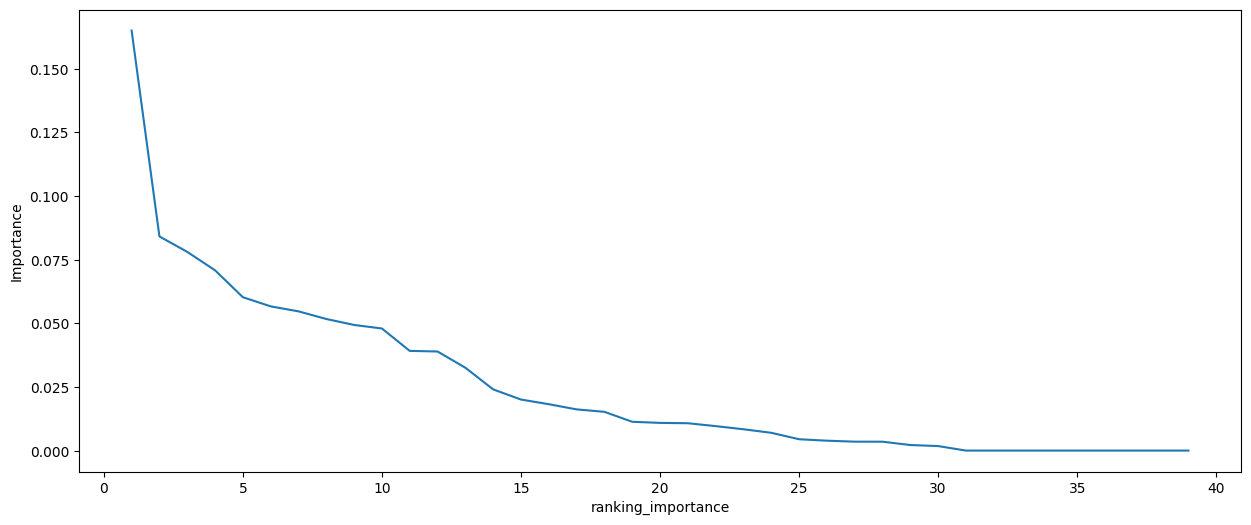

In [34]:
feature_importances_df = pd.DataFrame()
feature_importances_df['feature'] = X_train.columns
feature_importances_df['Importance'] = best_model.feature_importances_
feature_importances_df  = feature_importances_df.sort_values('Importance', ascending=False)
feature_importances_df['ranking_importance'] = np.arange(1, feature_importances_df.shape[0]+1, 1)

plt.figure(figsize = (15,6))
sns.lineplot(data = feature_importances_df, x = 'ranking_importance', y = 'Importance')
plt.show()

In [35]:
feature_importances_df

,feature,Importance,ranking_importance
9,Contract_Two year,0.164966,1
16,OnlineBackup_No internet service,0.084112,2
12,InternetService_Fiber optic,0.078045,3
23,StreamingMovies_No internet service,0.070815,4
28,TechSupport_Yes,0.060244,5
7,tenure,0.056643,6
21,PaymentMethod_Electronic check,0.054687,7
10,DeviceProtection_No internet service,0.051689,8
13,InternetService_No,0.049344,9
8,Contract_One year,0.047957,10


In [36]:
feature_importances_df['Importance_cumsum'] = feature_importances_df['Importance'].cumsum()

# can set importance_threshold to appropriate percentage of cumulative Importance that you want to cutoff features at
importance_threshold = 0.80
print(len(feature_importances_df[round(feature_importances_df['Importance_cumsum'], 2) <= importance_threshold]), 'features at or below threshold of', str(int(round(importance_threshold * 100, 0))) + '%')
display(feature_importances_df[round(feature_importances_df['Importance_cumsum'], 2) <= importance_threshold].head(5))
feature_importances_df[round(feature_importances_df['Importance_cumsum'], 2) <= importance_threshold].tail(5)

12 features at or below threshold of 80%


,feature,Importance,ranking_importance,Importance_cumsum
9,Contract_Two year,0.164966,1,0.164966
16,OnlineBackup_No internet service,0.084112,2,0.249079
12,InternetService_Fiber optic,0.078045,3,0.327123
23,StreamingMovies_No internet service,0.070815,4,0.397939
28,TechSupport_Yes,0.060244,5,0.458183


,feature,Importance,ranking_importance,Importance_cumsum
10,DeviceProtection_No internet service,0.051689,8,0.621202
13,InternetService_No,0.049344,9,0.670545
8,Contract_One year,0.047957,10,0.718502
18,OnlineSecurity_No internet service,0.039160,11,0.757662
27,TechSupport_No internet service,0.038914,12,0.796576


In [37]:
best_nb = len(feature_importances_df[round(feature_importances_df['Importance_cumsum'], 2) <= importance_threshold]) 
best_features = list(feature_importances_df[0:best_nb]['feature'])
len(best_features)

12

## Down Sampling

In [38]:
X_FE.columns = X_FE.columns.str.split('.').str[0]
import importlib
Pipe_Mod = Pipeline([
            ('Down Sampling', pp.Down_Sampling(target='Churn'))
            ])

In [39]:
X_train_down, y_train_down = Pipe_Mod.fit_transform(pd.concat([X_train, y_train], axis = 1), y = None)

**************************************************
Down Sampling**************************************************


## Model Training

In [40]:
# Calculate the ratio of negative class to positive class
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])
ratio

2.767475035663338

In [41]:
'Churn' in best_features # Making sure that target is not among the independent feature's list

False

In [42]:
importlib.reload(pp)
start=time.time()
### get best hyper parameters
best_model_after_fs = pp.grid_search(X_train[best_features], y_train, cv =  3, ratio = ratio)
end=time.time()
print ("time_spend: "+str(end-start))

**************************************************
get best hyper parameters

time_spend: 9.702971458435059


In [43]:
best_model_after_fs

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=500, reg_alpha=0, ...)

In [44]:
filename = 'Outputs/telecom_churn_model_v1.sav'
pickle.dump(best_model_after_fs, open(filename,'wb'))

In [45]:
# best_features = list(X_train.columns)

filename = 'Outputs/best_features_v1.sav'
pickle.dump(best_features, open(filename,'wb'))
print(len(best_features))

12


In [46]:
# filename = 'Outputs/Incomplete_Installation_prediction_best_model_v4.sav'
# best_model_after_fs = pickle.load(open(filename, 'rb'))

# filename = 'Outputs/best_features_v4.sav'
# best_features = pickle.load(open(filename, 'rb'))

In [47]:
for col in best_features:
    if 'Churn' in col:
        print(col)

## Model Evaluations and Lift Analysis

In [48]:
best_model_after_fs

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False, eta=0.05,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto',
              random_state=500, reg_alpha=0, ...)

In [49]:
X_test[best_features]

,Contract_Two year,OnlineBackup_No internet service,InternetService_Fiber optic,StreamingMovies_No internet service,TechSupport_Yes,tenure,PaymentMethod_Electronic check,DeviceProtection_No internet service,InternetService_No,Contract_One year,OnlineSecurity_No internet service,TechSupport_No internet service
1687,1.0,0.0,0.0,0.0,1.0,70.0,1.0,0.0,0.0,0.0,0.0,0.0
4506,0.0,1.0,0.0,1.0,0.0,4.0,0.0,1.0,1.0,0.0,1.0,1.0
4916,0.0,0.0,1.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0
1564,1.0,1.0,0.0,1.0,0.0,36.0,0.0,1.0,1.0,0.0,1.0,1.0
3378,0.0,1.0,0.0,1.0,0.0,18.0,0.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1451,0.0,0.0,0.0,0.0,1.0,66.0,0.0,0.0,0.0,1.0,0.0,0.0
3154,1.0,0.0,1.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0
3689,0.0,0.0,1.0,0.0,0.0,64.0,1.0,0.0,0.0,0.0,0.0,0.0
3251,0.0,0.0,1.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0


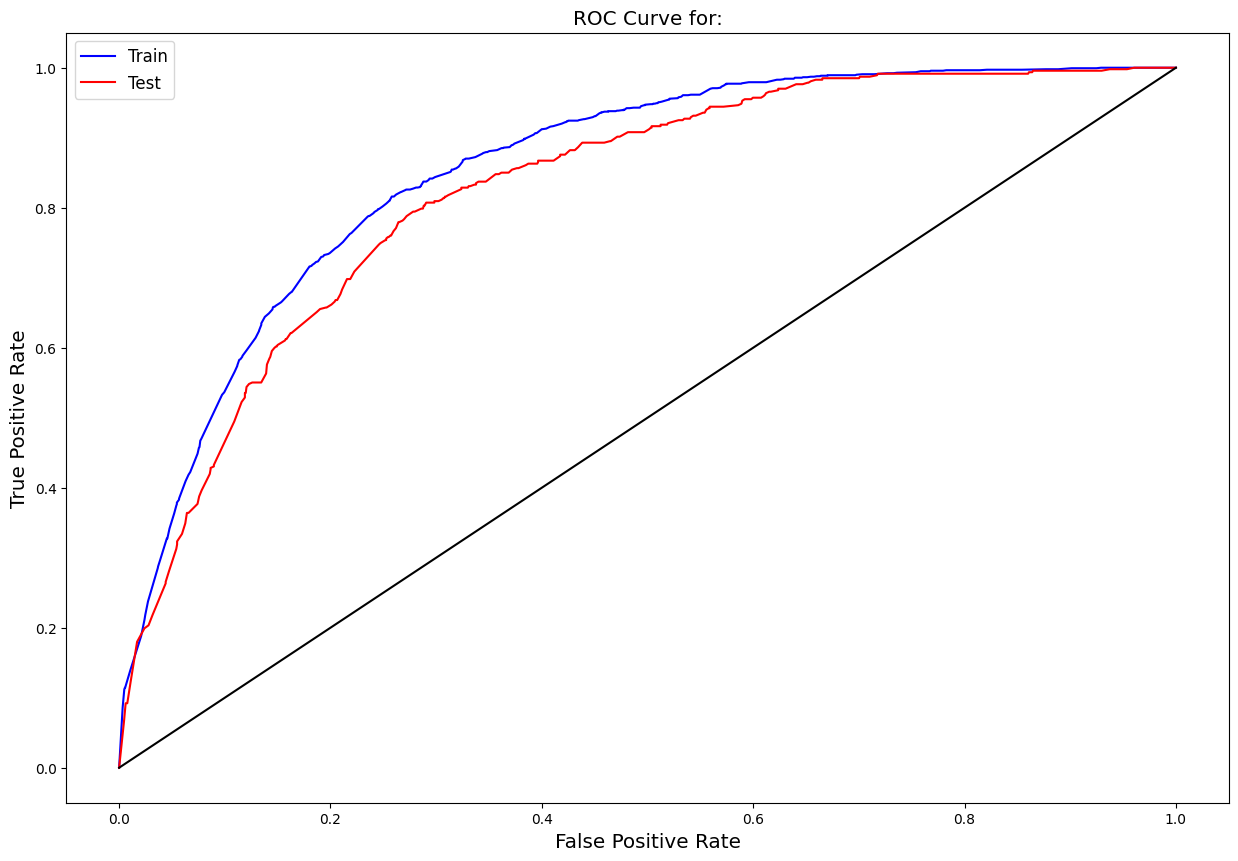

<Figure size 640x480 with 0 Axes>

In [50]:
importlib.reload(pp)
[metrics_summary, y_test_pred, y_test_proba, y_train_proba,y_proba,y_pred] = pp.model_evaluation (best_model_after_fs,X_train[best_features], y_train, X_train[best_features], y_train, X_test[best_features], y_test, X_FE[best_features], y)

In [51]:
metrics_summary

,Training down_sample,Training,Testing
Accuracy,0.754638,0.754638,0.736513
Recall,0.825250,0.825250,0.798715
Precision,0.524004,0.524004,0.502019
F1-Score,0.640997,0.640997,0.616529


In [52]:
from sklearn import metrics
#calculate AUC of model
auc = metrics.roc_auc_score(y_test, y_test_proba)

#print AUC score
print(auc)

0.8244218911861367


In [53]:
id

['customerID']

In [54]:
## Build final data
df_predict_actual                   = pd.DataFrame()
df_predict_actual['predict']        = y_pred
df_predict_actual['predict_prob']   = y_proba
df_predict_actual['customerID']         = raw_data_res['customerID']

df_predict_actual.head()

,predict,predict_prob,customerID
0,0,0.062878,9732-OUYRN
1,0,0.108898,0661-KQHNK
2,0,0.048022,4709-LKHYG
3,0,0.063954,9824-QCJPK
4,0,0.060855,4716-MRVEN


In [55]:
df_fixed    = df_predict_actual.sort_values(by = 'predict_prob', ascending = False).reset_index()
sample_size = df_predict_actual.shape[0]

# Segment the data into Decile size of 1
decile_size = sample_size/100 
df_fixed['Rank'] = ((df_predict_actual.index//decile_size)*1+1).astype('int64')

# df_fixed2 = df_fixed[df_fixed['Rank'] <= 20][['chc_id', 'Rank']]
df_fixed2 = df_fixed[['customerID', 'Rank']]
df_fixed2.head()

,customerID,Rank
0,7665-TOALD,1
1,5178-LMXOP,1
2,4910-GMJOT,1
3,0488-GSLFR,1
4,9725-SCPZG,1


## KS 

In [56]:
test_df = pd.concat([X_test[best_features], y_test], axis = 1)
test_df['Churn_probability'] = y_test_proba
test_df['y_pred'] = y_test_pred

In [57]:
y_test.sum()

467

In [58]:
test_df.shape

(1761, 15)

In [59]:
test_df.Churn.value_counts()

Churn
0    1294
1     467
Name: count, dtype: int64

In [60]:
importlib.reload(pp)
ks_df = pp.ks(data=test_df,target="Churn", prob= "Churn_probability")

In [61]:
ks_df

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.831737,0.935257,102,41,21.84%,3.17%,21.84%,3.17%,0.186731
2,0.745127,0.829139,100,75,21.41%,5.80%,43.25%,8.96%,0.342904
3,0.627100,0.743224,88,95,18.84%,7.34%,62.10%,16.31%,0.457925
4,0.536123,0.621110,70,128,14.99%,9.89%,77.09%,26.20%,0.508900
5,0.401123,0.536082,39,142,8.35%,10.97%,85.44%,37.17%,0.482674
6,0.280618,0.401002,25,150,5.35%,11.59%,90.79%,48.76%,0.420288
7,0.187958,0.279231,23,153,4.93%,11.82%,95.72%,60.59%,0.351300
8,0.083038,0.187484,16,159,3.43%,12.29%,99.14%,72.87%,0.262687
9,0.046959,0.082765,2,176,0.43%,13.60%,99.57%,86.48%,0.130957


In [62]:
ks_df

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.831737,0.935257,102,41,21.84%,3.17%,21.84%,3.17%,0.186731
2,0.745127,0.829139,100,75,21.41%,5.80%,43.25%,8.96%,0.342904
3,0.627100,0.743224,88,95,18.84%,7.34%,62.10%,16.31%,0.457925
4,0.536123,0.621110,70,128,14.99%,9.89%,77.09%,26.20%,0.508900
5,0.401123,0.536082,39,142,8.35%,10.97%,85.44%,37.17%,0.482674
6,0.280618,0.401002,25,150,5.35%,11.59%,90.79%,48.76%,0.420288
7,0.187958,0.279231,23,153,4.93%,11.82%,95.72%,60.59%,0.351300
8,0.083038,0.187484,16,159,3.43%,12.29%,99.14%,72.87%,0.262687
9,0.046959,0.082765,2,176,0.43%,13.60%,99.57%,86.48%,0.130957


## SHAP Feature Importance

In [63]:
import shap
explainer = shap.Explainer(best_model_after_fs, X_test[best_features])
shap_values = explainer(X_test[best_features])

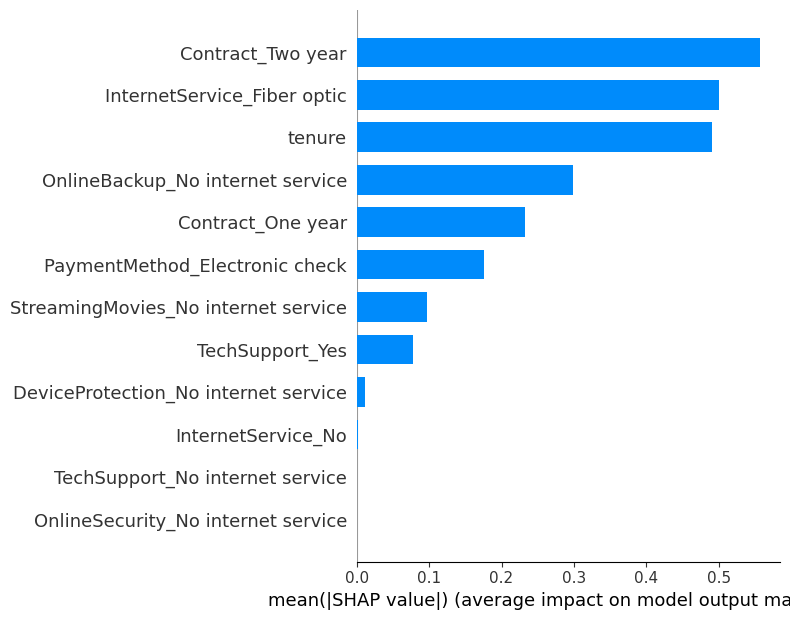

In [64]:
shap.summary_plot(shap_values, X_test[best_features], plot_type= 'bar')

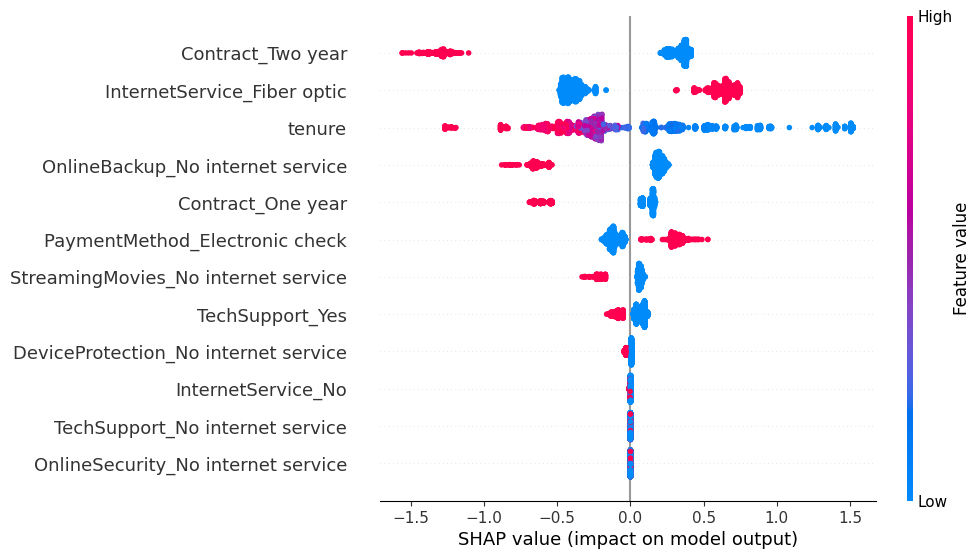

In [65]:
shap.plots.beeswarm(shap_values, max_display = 20)